# <center> <h1>Assignment 5</h1> </center>
<center> <h1>EIN 4933/6935 Python for Data Science Summer 2020</h1> </center>

Click the link below and download the file named "auto_mpg_modified.csv".<br/>
Link: https://sites.google.com/site/yasinunlu/home/research/new1/auto_mpg_modified.csv<br/>
You can find more info about the data set <a href="https://sites.google.com/site/yasinunlu/home/research/new1/auto_mpg_info.txt">here</a>. 

### Questions:
1) Read the file and create a dataframe and name it "df".<br/>
2) Perform the following data preprocessing:<br/>
a) Remove uncessary column(s) that cannot be used for training any models. Remove from df. Explain why you choose those column(s).<br/>
b) Determine any missing data point in df. Replace those missing data points with an imputated value. <br/>
c) Make sure columns labaled as "multi-valued discrete" are of integer type while "continuous" ones are of float type. You can read the column labels in this <a href="https://sites.google.com/site/yasinunlu/home/research/new1/auto_mpg_info.txt">file</a>. The final dataframe should be named "df_clean".<br/>
3) Prepare the following dataframes.<br/> 
a) Create a dataframe called "response" including only the column "mpg".<br/>
b) Create a dataframe called "features" with the remaining columns.<br/>
c) Prepare a dataframe named "features_train": random 80% rows of the dataframe "features"<br/>
d) Prepare a dataframe named "features_test": random 20% rows of the dataframe "features"<br/>
e) Prepare a dataframe named "response_train": random 80% rows of the dataframe "response"<br/>
f) Prepare a dataframe named "response_test": random 20% rows of the dataframe "response"<br/>
4) Create a multiple linear regressoin model from scikit learn package. Train your model using the train data that you created above. <br/>
5) Produce predictions over the test data.<br/>
6) Evaluate the model performance over the test data by tabulating metrics of Mean Absolute Error, Mean Squared Error and Root Mean Squared Error.<br/>
7) Normalize the data stored in df_clean. <br/>
8) Fit a multiple linear regression model using the normalized data.<br/>
9) Extract Feature Importance. That is, repor the coefficients (i.e. estimated parameters) of the fit model.<br/>
10) Summarize results with a bar chart.<br/>

In [1]:
import pandas as pd

# 1) Read the file and create a dataframe and name it "df".
df = pd.read_csv("auto_mpg_modified.csv")

# 2) Perform the following data preprocessing: 
df_clean = df.copy()

# b) Determine any missing data point in df. Replace those missing data points with an imputated value.
cyl_na_idx = df_clean[df_clean.cylinders.isna()].index  # create index to verify later
hp_na_idx = df_clean[df_clean.horsepower.isna()].index  # create index to verify later
origin_na_idx = df_clean[df_clean.origin.isna()].index  # create index to verify later

## Impute cylinders by displacement
# Since none of the missing valuse have displacements within the overlapping ranges between cylinders, I will impute cylinders based on the standard ranges for displacement. There are no missing values in the 4 cylinder range so I don't have to worry about those.

# set NaN values for displacement greater than 262 for 8 cylinders
df_clean.loc[(df_clean['displacement']>262) & (df_clean['cylinders'].isna()), 'cylinders'] = 8.0

# set NaN values for displacement less than 262 for 6 cylinders
df_clean.loc[(df_clean['displacement']<262) & (df_clean['cylinders'].isna()), 'cylinders'] = 6.0



## Impute horsepower by cylinders
# Since horsepower probably depends on the number of cylinders in the engine and the displacement, we should **not** impute horsepower with just the mean of the *entire column*. 
# For simplicity I will replace the horsepower for 6 cylinder engines with the average horsepower for that group and then do the same for 4 cylinder engines.

# calculate the mean values
mean_4cyl = round(df_clean.loc[df_clean['cylinders']==4.0, 'horsepower'].mean())
mean_6cyl = round(df_clean.loc[df_clean['cylinders']==6.0, 'horsepower'].mean())

# set NaN values for horsepower of 6 cylinder engines to the mean hp for 6 cylinders
df_clean.loc[(df_clean['cylinders']==6.0) & (df_clean['horsepower'].isna()), 'horsepower'] = mean_6cyl

# set NaN values for horsepower of 4 cylinder engines to the mean hp for 4 cylinders
df_clean.loc[(df_clean['cylinders']==4.0) & (df_clean['horsepower'].isna()), 'horsepower'] = mean_4cyl



## Impute Origin by origin of other vehicles with the same make
# Since, in this data set, all other vehicles by the same *make* (i.e "dodge") are from the same origin, I will replace `NaN` values in 'origin' column with the mean value from other cars of the same make (since all othe origins for a make are all the same, taking the mean will give me that value).

vehicle_makes = ["chevrolet","volkswagen","dodge","renault","peugeot","chrysler"]

for make in vehicle_makes:
    mean = df_clean.loc[df_clean['name'].str.contains(make), 'origin'].mean()   # find the mean
    # replace origin NaN for that make with its mean 
    df_clean.loc[(df_clean['name'].str.contains(make)) & (df_clean['origin'].isna()), 'origin'] = mean  


## Remove `name` column `cylinders`, and `horespower`
# Since the name column is all (mostly) unique values of type string it won't add any predictive ability so I will remove it. For now, I will let all other columns remain.

# a) Remove uncessary column(s) that cannot be used for training any models. Explain why you choose those column(s).
df_clean.drop("name", axis=1, inplace=True)


# c) Make sure columns labaled as "multi-valued discrete" are of integer type while "continuous" ones are of float type.
# df_clean['cylinders'] = df_clean['cylinders'].astype(int)
df_clean['year'] = df_clean['year'].astype(int) # drop from df?
df_clean['origin'] = df_clean['origin'].astype(int)

***
## Remove other columns: `cylinders`, and `horsepower`
Since the name column is all (mostly) unique values of type string it won't add any predictive ability so I will remove it. For now, I will let all other columns remain.


full df_clean: (398, 8)
features_train: (318, 7)
features_test: (80, 7)
response_train: (318, 1)
response_test: (80, 1)


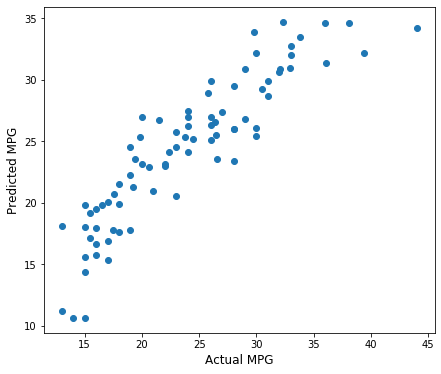

In [2]:
# Remove non-significant predictors
df_new = df_clean.drop(["cylinders","horsepower"], axis=1)

# 3) Prepare the following dataframes.

from sklearn.model_selection import train_test_split

# a) Create a dataframe called "response" including only the column "mpg".
response = df_clean[['mpg']]

# b) Create a dataframe called "features" with the remaining columns.
features = df_clean.iloc[:,1:]


# c) Prepare a dataframe named "features_train": random 80% rows of the dataframe "features"
# d) Prepare a dataframe named "features_test": random 20% rows of the dataframe "features"
# e) Prepare a dataframe named "response_train": random 80% rows of the dataframe "response"
# f) Prepare a dataframe named "response_test": random 20% rows of the dataframe "response"

result_list = train_test_split(features, response, test_size=0.2, random_state=64)

features_train, features_test, response_train, response_test = result_list

print("full df_clean:", df_clean.shape)
print("features_train:", features_train.shape)
print("features_test:", features_test.shape)
print("response_train:", response_train.shape)
print("response_test:", response_test.shape)

# 4) Create a multiple linear regressoin model from scikit learn package. 
# Train the model using the train data created above.

from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(features_train, response_train)

# 5) Produce predictions over the test data.

response_pred = mlr.predict(features_test)


# 6) Evaluate the model performance over the test data by tabulating metrics of Mean Absolute Error, Mean Squared Error and Root Mean Squared Error.

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 6))
plt.scatter(response_test, response_pred)
plt.ylabel('Predicted MPG', size = 12)
plt.xlabel('Actual MPG', size = 12)
plt.show()

In [53]:
import numpy as np
from sklearn import metrics
results_dict = {'Mean Absolute Error':round(metrics.mean_absolute_error(response_test, response_pred), 4),
    'Mean Squared Error':round(metrics.mean_squared_error(response_test, response_pred), 4),
    'Root Mean Squared Error':round(np.sqrt(metrics.mean_squared_error(response_test, response_pred)), 4),
    'R squared':round(metrics.r2_score(response_test, response_pred), 4)}

results_df = pd.DataFrame(results_dict.items(), columns=['metric','Model_1'])
results_df

,metric,Model_1
0,Mean Absolute Error,2.4539
1,Mean Squared Error,9.4026
2,Root Mean Squared Error,3.0664
3,R squared,0.8048


# 7) Normalize the data stored in df_clean.

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
data_normalized = scaler.fit_transform(df_clean)
df_normalized = pd.DataFrame(data_normalized, columns = df_clean.columns.to_list())

df_normalized.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,0.239362,1.0,0.617571,0.456522,0.536150,0.238095,0.0,0.0
1,0.159574,1.0,0.728682,0.646739,0.589736,0.208333,0.0,0.0
2,0.239362,1.0,0.645995,0.565217,0.516870,0.178571,0.0,0.0
3,0.186170,1.0,0.609819,0.565217,0.516019,0.238095,0.0,0.0
4,0.212766,1.0,0.604651,0.510870,0.520556,0.148810,0.0,0.0


# 8) Fit a multiple linear regression model using the normalized data.

In [36]:
from sklearn.linear_model import LinearRegression
mlr_norm = LinearRegression()
features_norm = df_normalized.iloc[:,1:]
response_norm = df_normalized[['mpg']]
mlr_norm.fit(features_norm, response_norm) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# 9) Extract Feature Importance. 

Report the coefficients (i.e. estimated parameters) of the fit model.

In [44]:
importance = mlr_norm.coef_[0].round(4)      # list of estimated coeff parameters 
feature_names = df_normalized.columns.to_list()
feature_names.remove('mpg')
# summarize feature importance
for i, score in enumerate(importance):
    print('%s: %.5f' % (feature_names[i], score))

cylinders: -0.05610
displacement: 0.19850
horsepower: -0.06780
weight: -0.62550
acceleration: 0.04100
year: 0.24070
origin: 0.07630


In [45]:
mlr_norm.coef_[0].round(4)

array([-0.0561,  0.1985, -0.0678, -0.6255,  0.041 ,  0.2407,  0.0763])

In [49]:
coef_df = pd.DataFrame(importance, index=feature_names, columns=["Model_1"])
coef_df

,Model_1
cylinders,-0.0561
displacement,0.1985
horsepower,-0.0678
weight,-0.6255
acceleration,0.0410
year,0.2407
origin,0.0763


In [24]:
importance = mlr_norm.coef_[0]      # list of estimated coeff parameters 
feature_names = df_normalized.columns.to_list()
feature_names.remove('mpg')
# summarize feature importance
for i, score in enumerate(importance):
    print('%s: %.5f' % (feature_names[i], score))

displacement: 0.11624
weight: -0.65727
acceleration: 0.06649
year: 0.24438
origin: 0.07148


## 10) Summarize results with a bar chart.

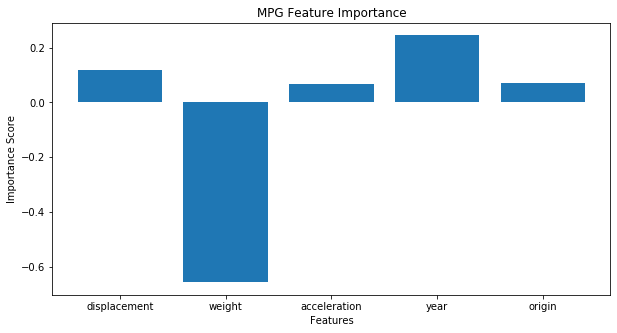

In [25]:
from matplotlib import pyplot
pyplot.figure(figsize=(10, 5))
# plot feature importance
pyplot.bar(x = list(range(len(importance))), height = importance, tick_label = feature_names)
pyplot.title('MPG Feature Importance')
pyplot.xlabel('Features')
pyplot.ylabel('Importance Score')
pyplot.show()

### Bonus Questions:
11) Analyze the results from the bar chart. Drop one or two least important features from df_clean.<br/>
12) Repeat Questions 3 - 6 and report the updated metrics of Mean Absolute Error, Mean Squared Error and Root Mean Squared Error. Compare the updated metric results agains the previous ones. 

In [26]:
#work on your code here and after.

In [27]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# diabetes = datasets.load_diabetes()
X = features_norm #diabetes.data
y = response_norm #diabetes.target

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     356.9
Date:                Fri, 03 Jul 2020   Prob (F-statistic):          1.88e-143
Time:                        16:24:28   Log-Likelihood:                 402.08
No. Observations:                 398   AIC:                            -792.2
Df Residuals:                     392   BIC:                            -768.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4285      0.024     17.737   